# EDA and Feature Engineering for Meta Data
## Import necessary libraries

In [1]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
from collections import defaultdict
from collections import Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')
sns.set(style='white', context='notebook', palette='deep')

## Load preprocessed data

In [2]:
# Load nontext data
file = open('../data/preprocessed/nontext_data.pickle', 'rb')
nontext_data = pickle.load(file)
file.close()

print(nontext_data.shape)
nontext_data.head()

(403, 56)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,GDP_date,GDP_value,GDP_diff_prev,...,Hsales_diff_year,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1,1982-04-01,6830.251,0.456199,...,42.307692,7.428054,4.300007,7.854999,-2.571946,-5.699993,-2.145001,NaN,NaN,NaN
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1,1982-07-01,6804.139,-0.382299,...,34.831461,6.397952,2.690992,7.671351,-3.102048,-6.809008,-1.828649,-1.030102,-1.609015,-0.183648
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,1982-07-01,6804.139,-0.382299,...,45.026178,6.456348,2.749388,6.812592,-2.043652,-5.750612,-1.687408,0.058396,0.058396,-0.858759
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,1982-07-01,6804.139,-0.382299,...,14.004376,6.117343,2.410384,6.863442,-2.382657,-6.089616,-1.636558,-0.339005,-0.339005,0.050851
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,1982-07-01,6804.139,-0.382299,...,14.004376,6.117343,2.410384,6.863442,-2.382657,-6.089616,-1.636558,0.000000,0.000000,0.000000


In [3]:
# Load nontext moving average data
file = open('../data/preprocessed/nontext_ma2.pickle', 'rb')
nontext_ma2 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma3.pickle', 'rb')
nontext_ma3 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma6.pickle', 'rb')
nontext_ma6 = pickle.load(file)
file.close()
file = open('../data/preprocessed/nontext_ma12.pickle', 'rb')
nontext_ma12 = pickle.load(file)
file.close()

# EDA on nontext dataset

In [4]:
# Add previous rate decision to see inertia effect
nontext_data['prev_decision'] = nontext_data['RateDecision'].shift(1)
nontext_data['next_decision'] = nontext_data['RateDecision'].shift(-1)
nontext_data[['RateDecision', 'prev_decision', 'next_decision']].head()

,RateDecision,prev_decision,next_decision
date,,,
1982-10-05,-1,<NA>,-1
1982-11-16,-1,-1,0
1982-12-21,0,-1,0
1983-01-14,0,0,0
1983-01-21,0,0,0


In [5]:
# # Take the same period as text dataset (--> Removed as it is determined later)
# nontext_data = nontext_data.loc[nontext_data.index > dt.datetime(1994,1,1)]
# nontext_ma2 = nontext_ma2.loc[nontext_ma2.index > dt.datetime(1994,1,1)]
# nontext_ma3 = nontext_ma3.loc[nontext_ma3.index > dt.datetime(1994,1,1)]
# nontext_ma6 = nontext_ma6.loc[nontext_ma6.index > dt.datetime(1994,1,1)]
# nontext_ma12 = nontext_ma12.loc[nontext_ma12.index > dt.datetime(1994,1,1)]

In [6]:
nontext_data.describe()

,Rate,RateDiff,RateDecision,GDP_value,GDP_diff_prev,GDP_diff_year,GDPPOT_value,GDPPOT_diff_prev,GDPPOT_diff_year,PCE_value,...,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff,prev_decision,next_decision
count,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,...,403.000000,403.000000,403.000000,403.000000,403.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,4.008375,-0.025434,-0.012407,12669.954814,0.656566,2.520181,12867.906829,0.649468,2.641442,80.986280,...,3.410522,2.920850,0.033236,-0.627629,-1.117301,0.000871,0.007417,-0.020671,-0.014925,-0.009950
std,3.095126,0.244006,0.579367,3682.343568,1.108494,2.256358,3734.733297,0.185275,0.755643,18.882344,...,2.058449,2.424826,1.994108,2.247555,0.711788,0.479102,0.473898,0.206978,0.577877,0.577984
min,0.000000,-1.000000,-1.000000,6804.139000,-8.937251,-9.083737,7271.207419,0.318708,1.303969,47.686000,...,0.000000,-1.171526,-4.920215,-8.061836,-2.699376,-4.719386,-3.285667,-1.073513,-1.000000,-1.000000
25%,1.000000,0.000000,0.000000,9347.597000,0.403529,1.616301,9566.609346,0.485876,1.943999,66.533000,...,2.229200,0.664919,-1.507443,-1.722488,-1.589424,-0.153138,-0.126778,-0.048219,0.000000,0.000000
50%,4.000000,0.000000,0.000000,12888.281000,0.679037,2.717886,12624.018850,0.645236,2.630692,79.796000,...,3.459268,3.013240,-0.044488,-0.372375,-1.191197,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,0.000000,0.000000,15709.562000,1.007987,3.988106,15962.647180,0.779229,3.160218,94.957000,...,4.739393,4.579390,1.435038,0.452855,-0.578873,0.138957,0.130769,0.034403,0.000000,0.000000
max,11.500000,1.125000,1.000000,19805.962000,7.547535,12.226677,20003.730000,1.058177,4.280368,120.047000,...,8.183339,8.901506,8.042614,7.810175,0.000000,3.823485,2.794548,0.674873,1.000000,1.000000


In [7]:
nontext_data.isnull().sum()

unscheduled           0
forecast              0
confcall              0
ChairPerson           0
Rate                  0
RateDiff              0
RateDecision          0
GDP_date              0
GDP_value             0
GDP_diff_prev         0
GDP_diff_year         0
GDPPOT_date           0
GDPPOT_value          0
GDPPOT_diff_prev      0
GDPPOT_diff_year      0
PCE_date              0
PCE_value             0
PCE_diff_prev         0
PCE_diff_year         0
CPI_date              0
CPI_value             0
CPI_diff_prev         0
CPI_diff_year         0
Unemp_date            0
Unemp_value           0
Unemp_diff_prev       0
Unemp_diff_year       0
Employ_date           0
Employ_value          0
Employ_diff_prev      0
Employ_diff_year      0
PMI_date              0
PMI_value             0
PMI_diff_prev         0
PMI_diff_year         0
NMI_date            281
NMI_value           281
NMI_diff_prev       281
NMI_diff_year       298
Rsales_date         116
Rsales_value        116
Rsales_diff_prev

Count: 
0     268
-1     70
1      65
Name: RateDecision, dtype: Int64
Percent: 
0     67.0
-1    17.0
1     16.0
Name: RateDecision, dtype: Float64


Text(0.5, 1.0, 'nontext_data')

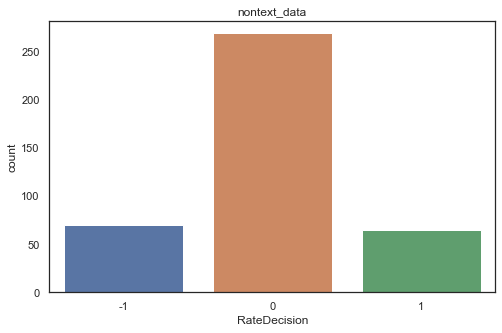

In [8]:
# The number of data per Target Labels
x = nontext_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
# sns.barplot(x.index, x)
# plt.gca().set_ylabel('number of samples')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=nontext_data)
ax.set_title('nontext_data')

Highly imbalanced to 0 (hold), so need to consider this point. Always predicting 0 (hold) will result in the accuracy of more than 60%. 

## Correlation

In [9]:
nontext_data.columns.values

array(['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate',
       'RateDiff', 'RateDecision', 'GDP_date', 'GDP_value',
       'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_date', 'GDPPOT_value',
       'GDPPOT_diff_prev', 'GDPPOT_diff_year', 'PCE_date', 'PCE_value',
       'PCE_diff_prev', 'PCE_diff_year', 'CPI_date', 'CPI_value',
       'CPI_diff_prev', 'CPI_diff_year', 'Unemp_date', 'Unemp_value',
       'Unemp_diff_prev', 'Unemp_diff_year', 'Employ_date',
       'Employ_value', 'Employ_diff_prev', 'Employ_diff_year', 'PMI_date',
       'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 'NMI_date',
       'NMI_value', 'NMI_diff_prev', 'NMI_diff_year', 'Rsales_date',
       'Rsales_value', 'Rsales_diff_prev', 'Rsales_diff_year',
       'Hsales_date', 'Hsales_value', 'Hsales_diff_prev',
       'Hsales_diff_year', 'Taylor', 'Balanced', 'Inertia', 'Taylor-Rate',
       'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff',
       'Inertia_diff', 'prev_decision', 'next_decisio

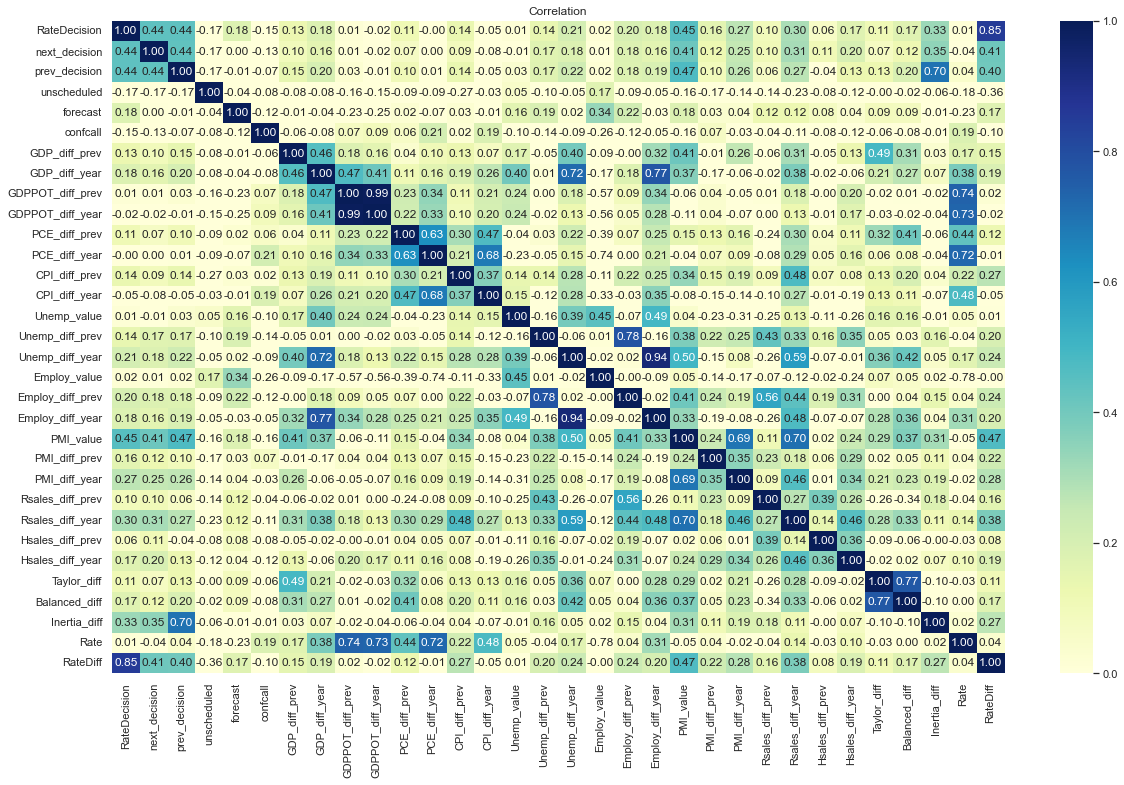

In [11]:
# Per document type
corr_columns = ['RateDecision', 'next_decision', 'prev_decision', 'unscheduled', 'forecast', 'confcall', 
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Rate', 'RateDiff']

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax)
ax.set_title("Correlation")
plt.show()

Observation on the correlation:

Higher correlation with Rate Decision:
 * 'GDP_diff_prev'
 * 'Unemp_diff_year'
 * 'Employ_diff_prev'
 * 'PMI_value'
 * 'Rsales_diff_year'
 * 'Hsales_diff_year'
 * 'prev_decision'
 * 'Taylor_diff'
 * 'Balanced_diff'
 * 'Inertia_diff'

Low correlation with Rate Decision:
 *  'unscheduled' - correlation is small
 * 'forecast' - logically not related
 * 'confcall' - correlation is small
 * 'GDP_diff_year' - use GDP_diff_prev instead, which highly correlate to this
 * 'GDPPOT_diff_prev' - correlation is small
 * 'GDPPOT_diff_year' - correlation is small
 * 'PCE_diff_prev' - correlation is small
 * 'PCE_diff_year' - correlation is small
 * 'CPI_diff_prev' - correlation is small
 * 'CPI_diff_year' - correlation is small
 * 'Unemp_value' - correlation is small
 * 'Unemp_diff_prev' - use Unemp_diff_year instead, which highly correlate to this
 * 'Employ_value' - correlation is small
 * 'Employ_diff_year' - use Employ_diff_prev instead, which highly correlate to this
 * 'PMI_diff_prev' - correlation is small
 * 'PMI_diff_year' - correlation is small
 * 'Rsales_diff_prev' - correlation is small
 * 'Rsales_diff_year' - correlation is small
 * 'Hsales_diff_prev' - correlation is small
 * 'Hsales_diff_year' - correlation is small
 * 'next_decision' - this was added to see whether there's any meaningful correlation from previous period

Will create two dataset, one full set and the other smaller set with high correlation

### Moving average

In [12]:
corr_columns = ['RateDecision',
                'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                'Taylor_diff', 'Balanced_diff', 'Inertia_diff', 'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate']

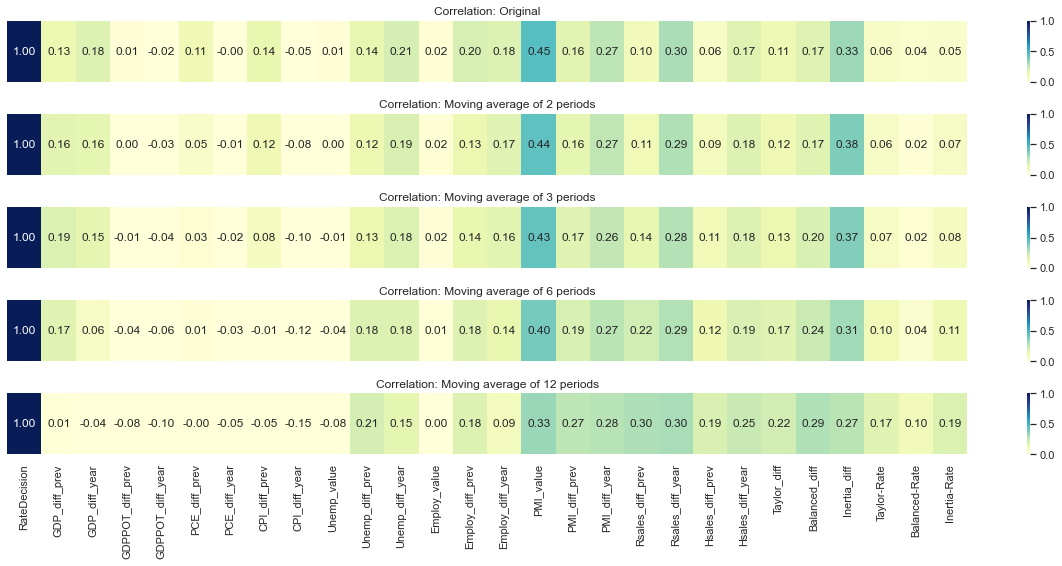

In [13]:
# Moving average (window = 2)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(17,8))

sns.heatmap(nontext_data[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Correlation: Original")
ax1.set_xticks([])
ax1.set_yticks([])
sns.heatmap(nontext_ma2[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Correlation: Moving average of 2 periods")
ax2.set_xticks([])
ax2.set_yticks([])
sns.heatmap(nontext_ma3[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax3)
ax3.set_title("Correlation: Moving average of 3 periods")
ax3.set_xticks([])
ax3.set_yticks([])
sns.heatmap(nontext_ma6[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax4)
ax4.set_title("Correlation: Moving average of 6 periods")
ax4.set_xticks([])
ax4.set_yticks([])
sns.heatmap(nontext_ma12[corr_columns].astype(float).corr().iloc[:1], cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax5)
ax5.set_title("Correlation: Moving average of 12 periods")
ax5.set_yticks([])

fig.tight_layout(pad=1.0)
plt.show()


Not much improvement. The followings can be used:
 * Unemp_diff_prev for previous 3 period
 * Emp_diff_prev for previous 2 period
 * Rsales_diff_year for previous 2 period
 * Hsales_diff_year for previous 12 period
 * Balanced_diff for previous 12 period
 * Intertia_diff for previous 3 period

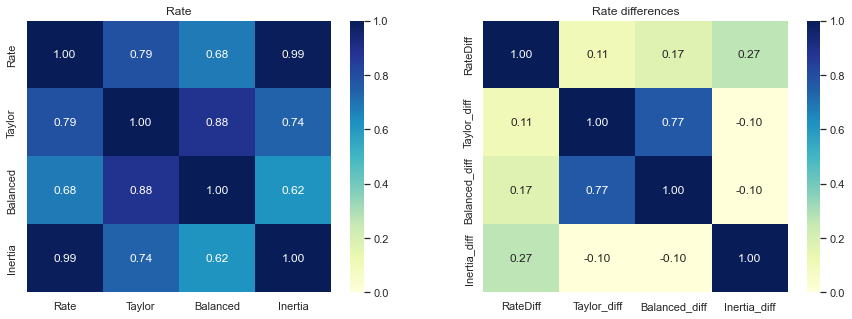

In [14]:
# Correlation between Taylor rule and actual rates are quite high

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

corr_columns = ['Rate', 'Taylor', 'Balanced', 'Inertia']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax1)
ax1.set_title("Rate")

corr_columns = ['RateDiff', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']
sns.heatmap(nontext_data[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax2)
ax2.set_title("Rate differences")

plt.show()

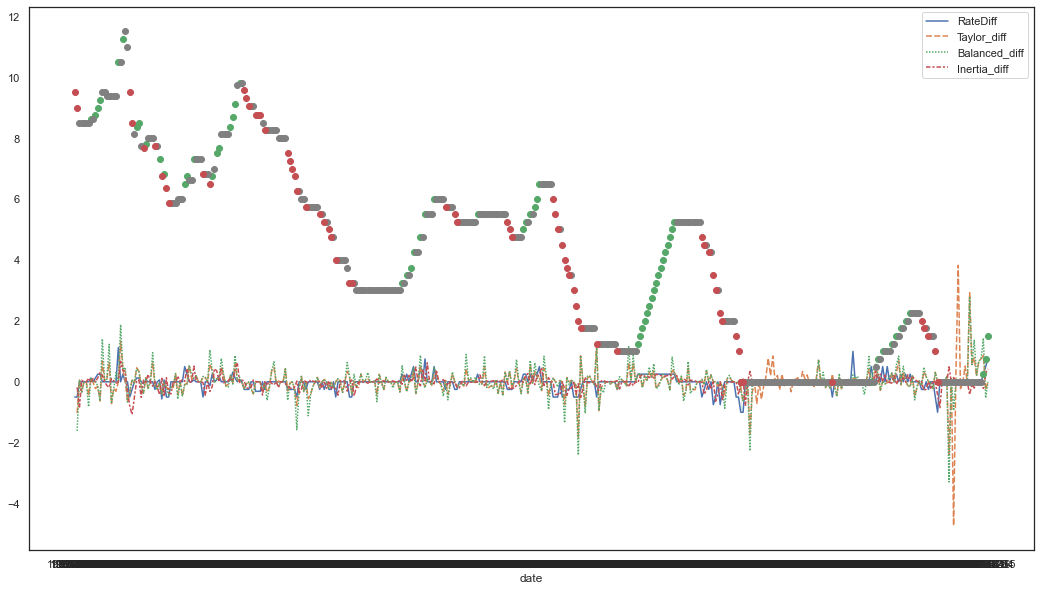

In [15]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=nontext_data[corr_columns], ax=ax)

decision_raise = nontext_data.loc[nontext_data['RateDecision'] == 1]
decision_hold = nontext_data.loc[nontext_data['RateDecision'] == 0]
decision_lower = nontext_data.loc[nontext_data['RateDecision'] == -1]

ax.plot(decision_raise.index.values, decision_raise['Rate'], 'o', color="g", label="Raise")
ax.plot(decision_hold.index.values, decision_hold['Rate'], 'o', color="grey", label="Hold")
ax.plot(decision_lower.index.values, decision_lower['Rate'], 'o', color="r", label="Lower")


### Check individual columns

In [50]:
def plot_distribution(df, columns):
    for col in columns:        
        fig, ax = plt.subplots(figsize=(10, 5))
        g = sns.kdeplot(df[col][(df["RateDecision"] == -1)], color="Red", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 0) & (df[col].notnull())], ax=g, color="Blue", shade=True)
        g = sns.kdeplot(df[col][(df["RateDecision"] == 1) & (df[col].notnull())], ax=g, color="Green", shade=True)
        g.set_xlabel(col)
        g.set_ylabel("Frequency")
        g.set_title("Distribution for " + col, fontsize=14)
        g = g.legend(["Lower", "Hold", "Raise"])
        
        g = sns.FacetGrid(df, col='RateDecision', height=3, aspect=1)
        g.map(sns.distplot, col)


In [51]:
#nontext_data = nontext_data.drop("2008-11-25")

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

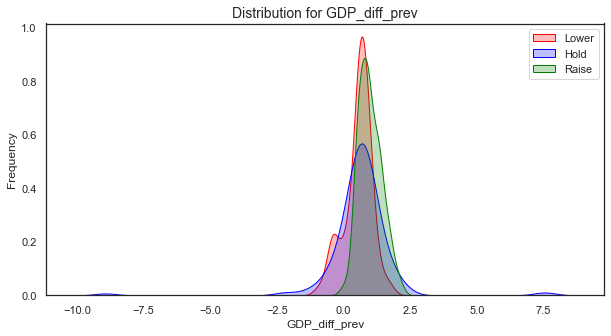

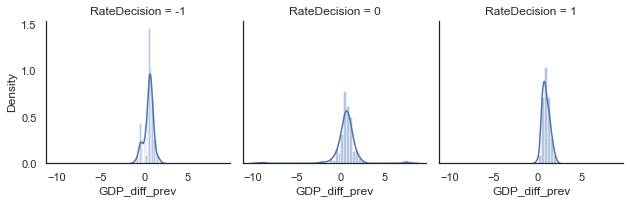

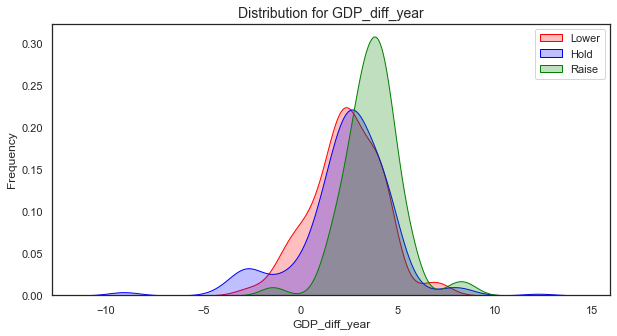

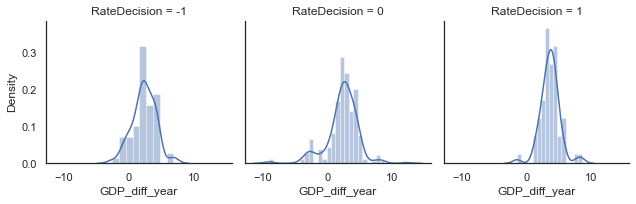

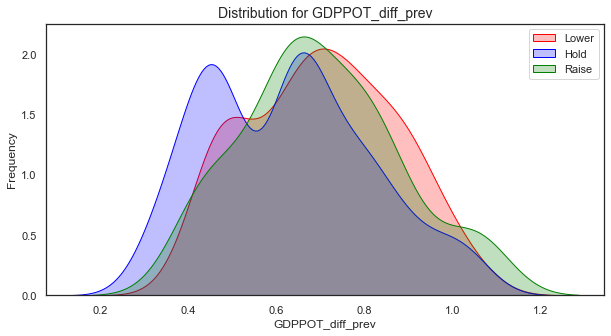

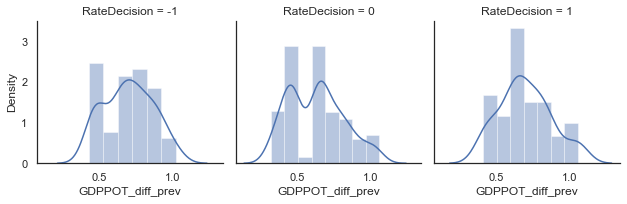

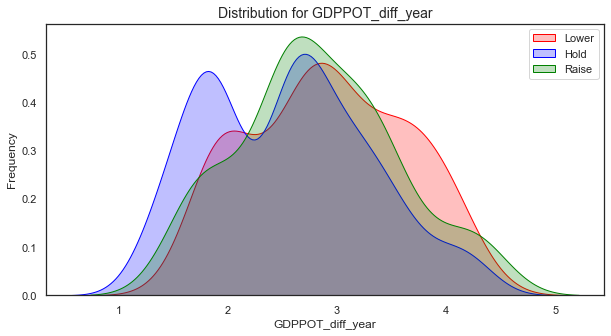

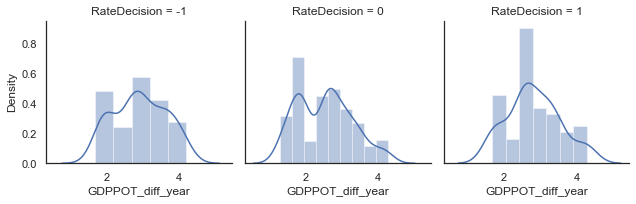

In [52]:
plot_distribution(nontext_data, ["GDP_diff_prev", "GDP_diff_year", "GDPPOT_diff_prev", "GDPPOT_diff_year"])

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

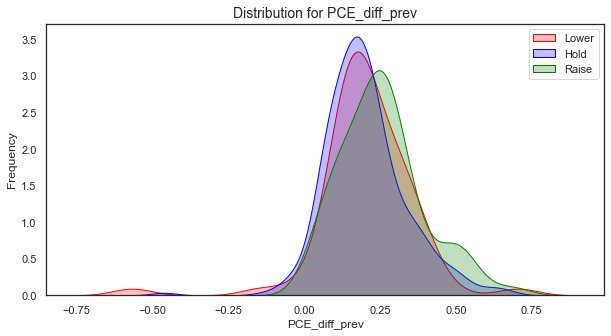

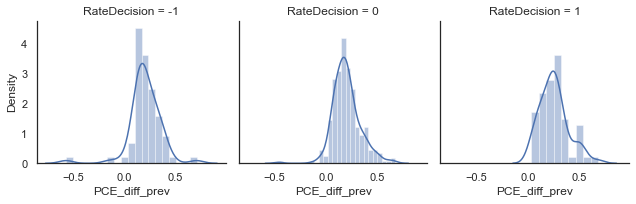

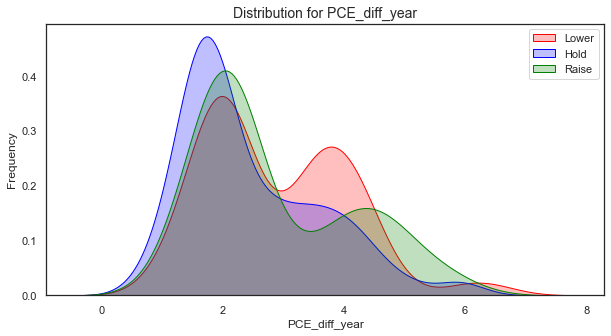

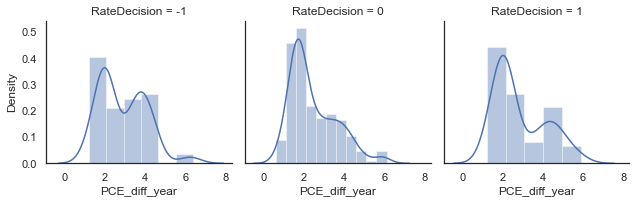

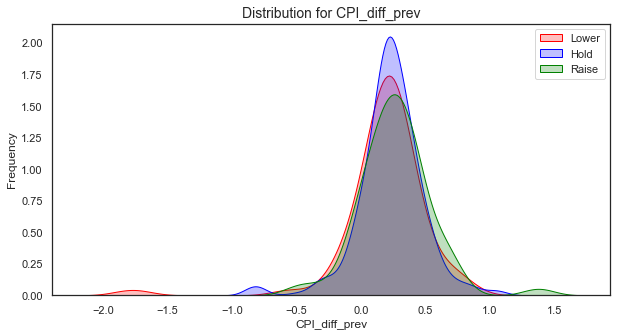

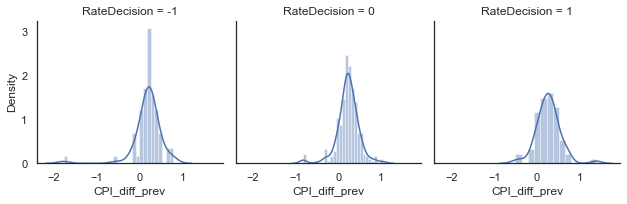

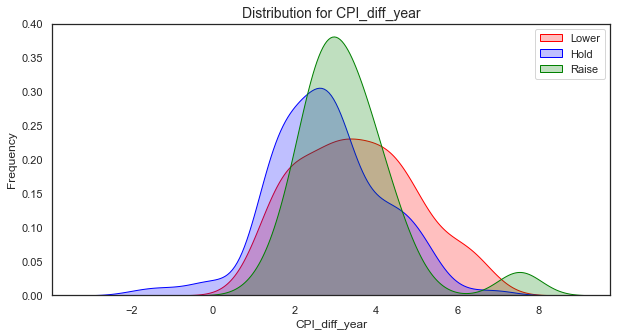

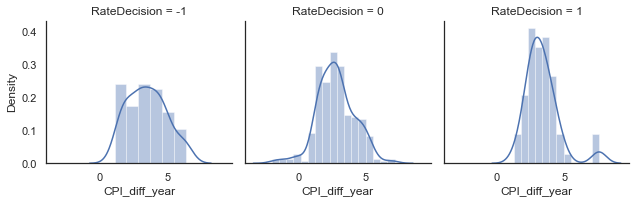

In [53]:
plot_distribution(nontext_data, ["PCE_diff_prev", "PCE_diff_year", "CPI_diff_prev", "CPI_diff_year"])

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

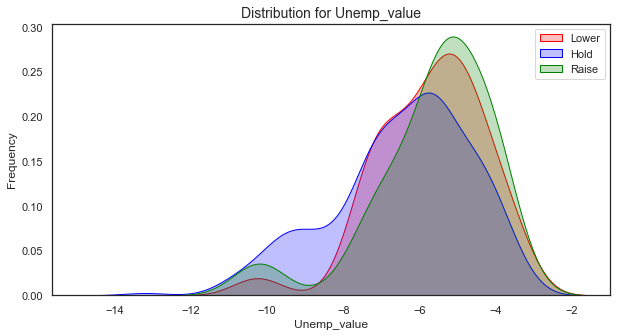

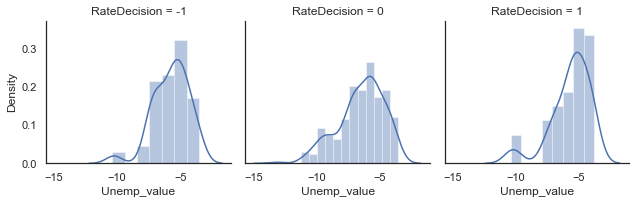

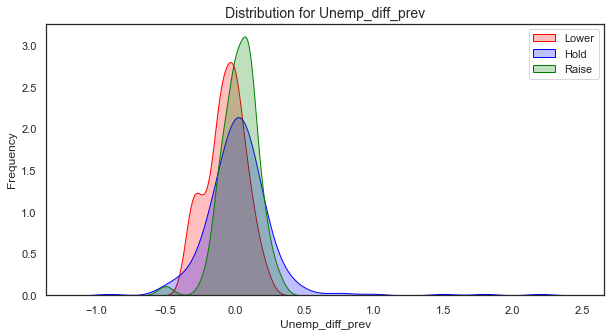

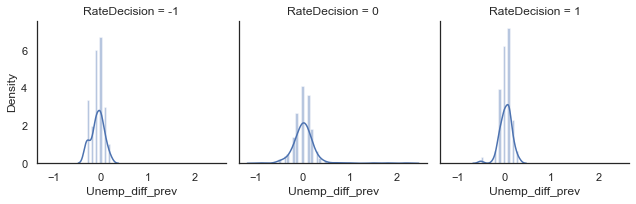

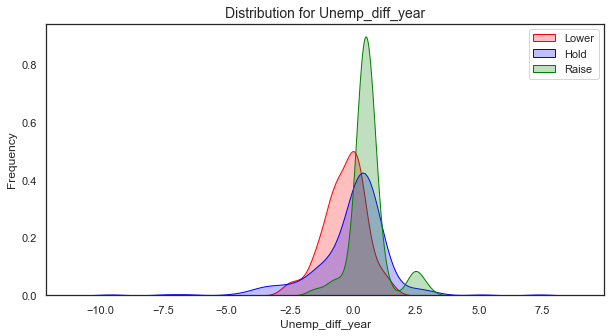

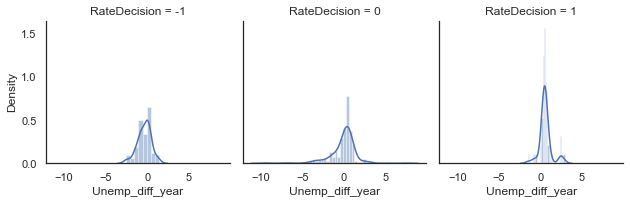

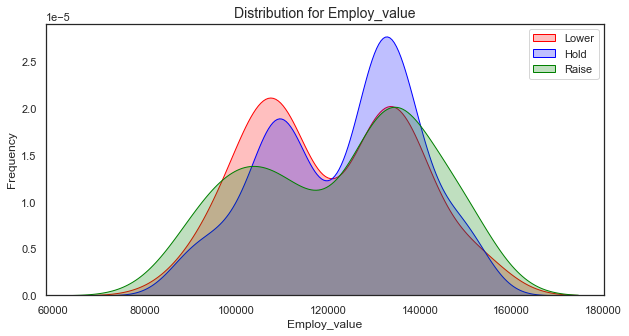

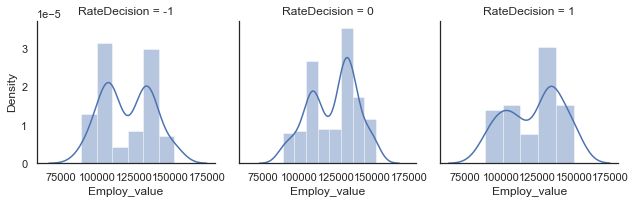

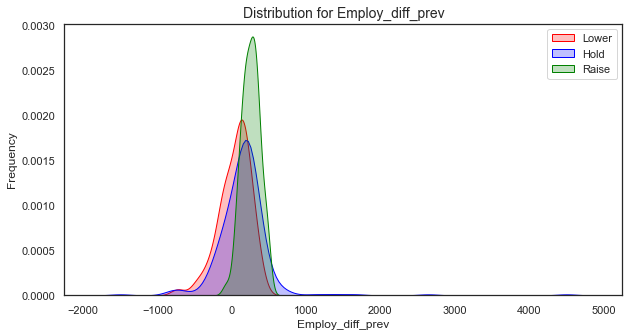

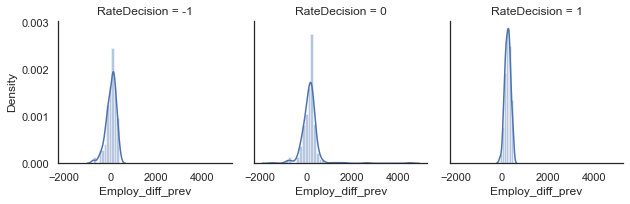

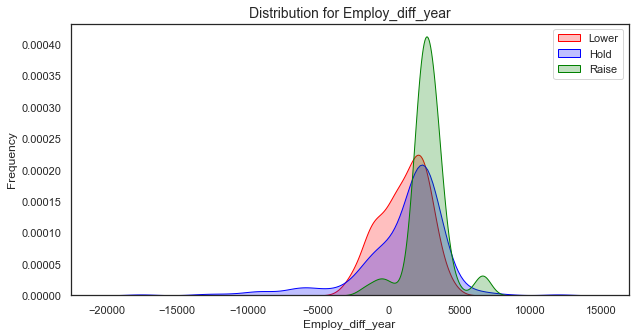

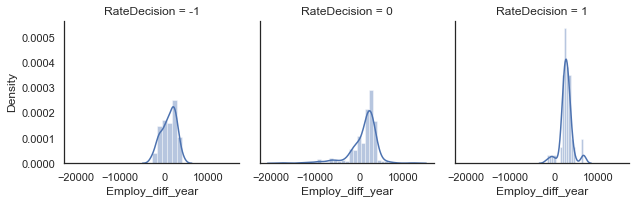

In [54]:
plot_distribution(nontext_data, ["Unemp_value", "Unemp_diff_prev", "Unemp_diff_year", "Employ_value", "Employ_diff_prev", "Employ_diff_year"])

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

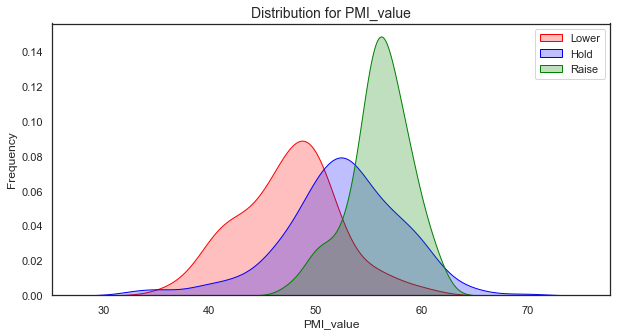

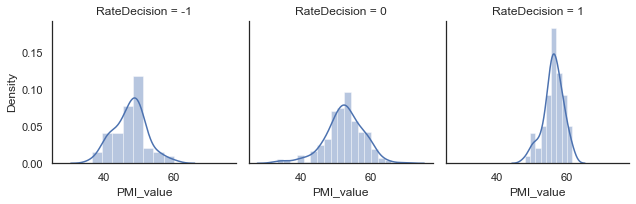

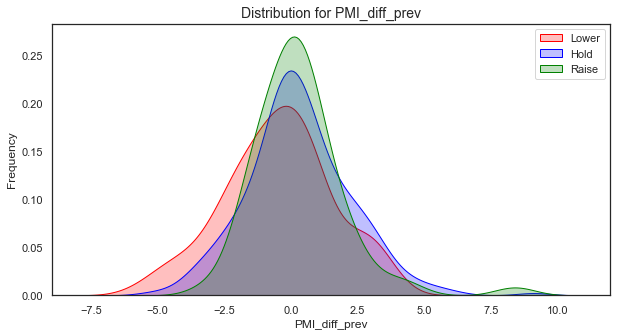

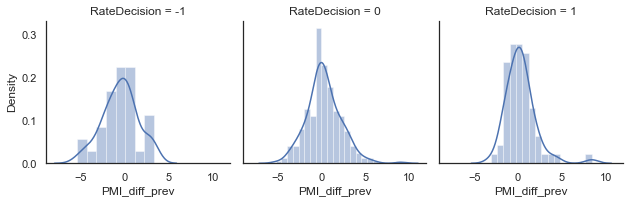

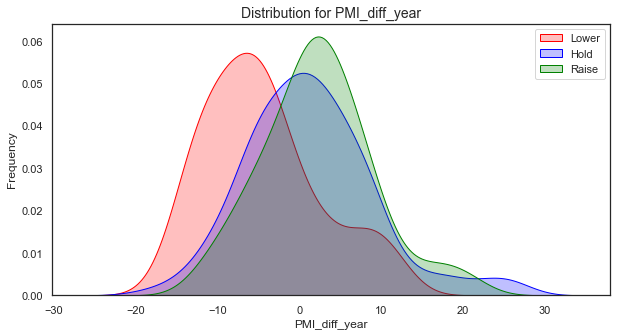

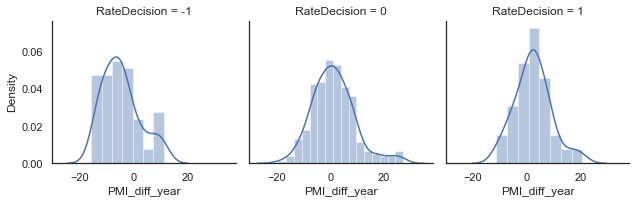

In [55]:
plot_distribution(nontext_data, ["PMI_value", "PMI_diff_prev", "PMI_diff_year"])

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

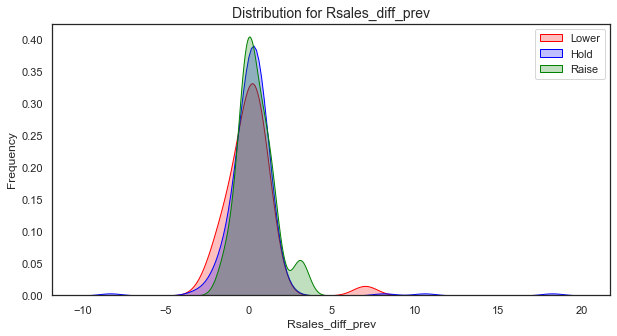

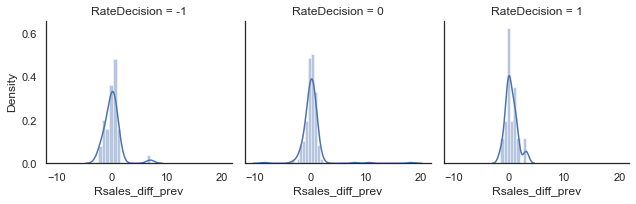

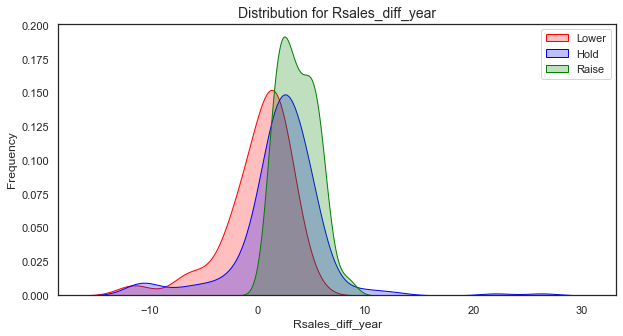

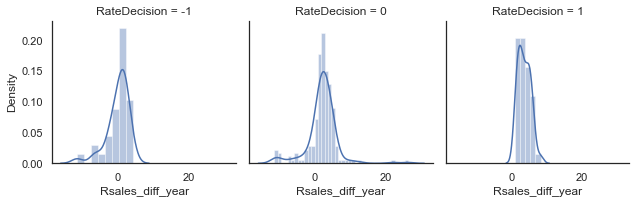

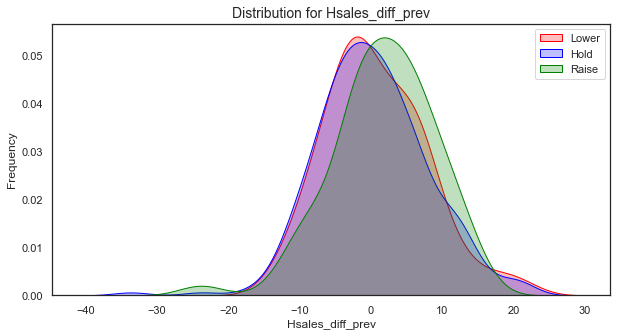

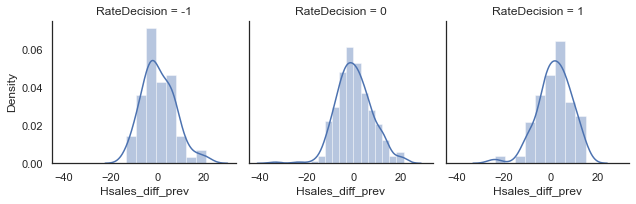

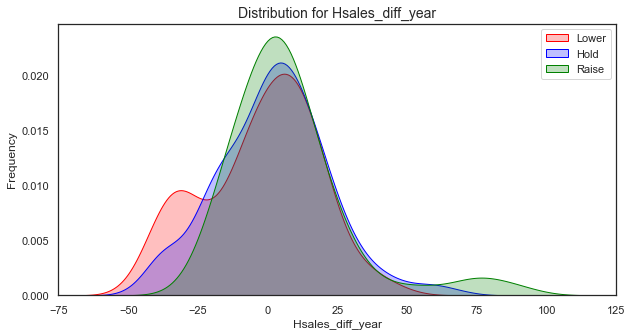

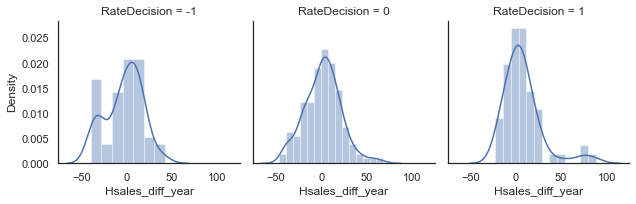

In [56]:
plot_distribution(nontext_data, ["Rsales_diff_prev", "Rsales_diff_year", "Hsales_diff_prev", "Hsales_diff_year"])

/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `hist

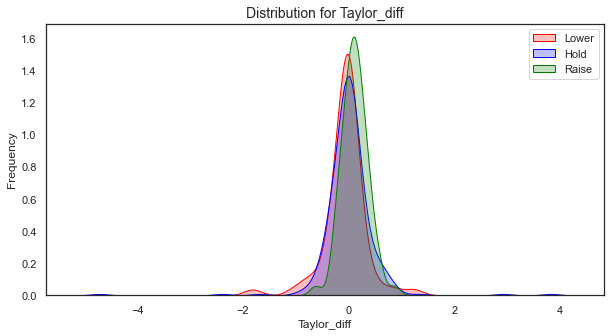

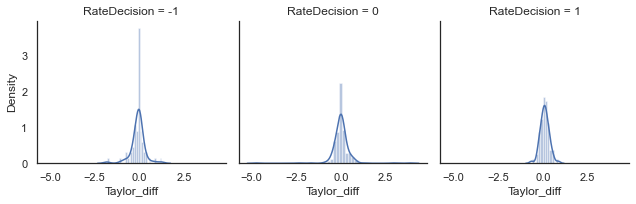

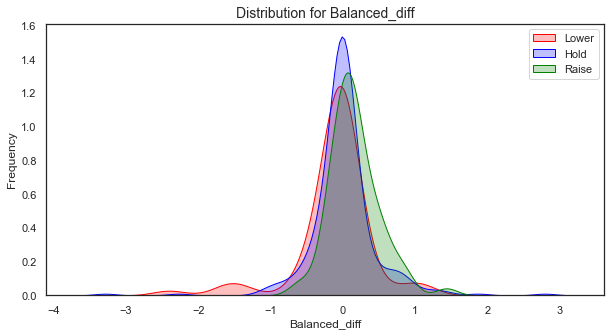

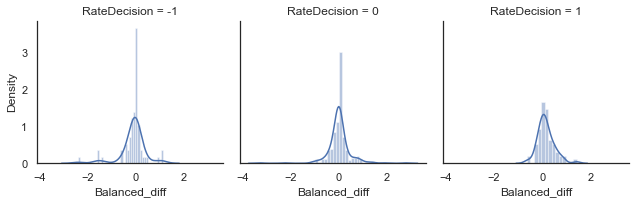

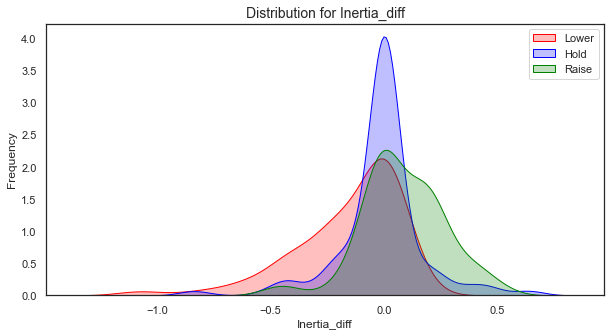

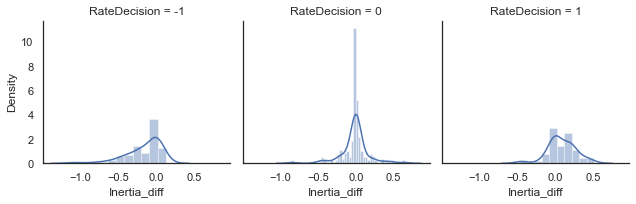

In [57]:
plot_distribution(nontext_data, ["Taylor_diff", "Balanced_diff", "Inertia_diff"])

## Create Training Data Set

In [60]:
nontext_train_small = pd.concat([nontext_data[['RateDecision', 'prev_decision', 'GDP_diff_prev', 'PMI_value']],
                                 nontext_ma2[['Employ_diff_prev', 'Rsales_diff_year']].drop("2008-11-25"), 
                                 nontext_ma3[['Unemp_diff_prev', 'Inertia_diff']].drop("2008-11-25"), 
                                 nontext_ma12[['Hsales_diff_year', 'Balanced_diff']].drop("2008-11-25")], axis=1)
nontext_train_small.rename(columns={'RateDecision': 'target'}, inplace=True)

In [61]:
nontext_train_small.isnull().sum()

target                0
prev_decision         1
GDP_diff_prev         0
PMI_value             0
Employ_diff_prev      0
Rsales_diff_year    131
Unemp_diff_prev       0
Inertia_diff          4
Hsales_diff_year      0
Balanced_diff        15
dtype: int64

In [64]:
# Large dataset to include all the latest figures plus 3 months rolling average

latest_columns = ['RateDecision', 'prev_decision',
                  'GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
                  'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
                  'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
                  'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
                  'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
                  'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
                  'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

ma3_columns = ['GDP_diff_prev', 'GDP_diff_year', 'GDPPOT_diff_prev', 'GDPPOT_diff_year',
               'PCE_diff_prev', 'PCE_diff_year', 'CPI_diff_prev', 'CPI_diff_year', 
               'Unemp_value', 'Unemp_diff_prev', 'Unemp_diff_year',
               'Employ_value', 'Employ_diff_prev', 'Employ_diff_year',
               'PMI_value', 'PMI_diff_prev', 'PMI_diff_year', 
               'Rsales_diff_prev', 'Rsales_diff_year', 'Hsales_diff_prev', 'Hsales_diff_year',
               'Taylor-Rate', 'Balanced-Rate', 'Inertia-Rate', 'Taylor_diff', 'Balanced_diff', 'Inertia_diff']

nontext_train_large = pd.concat([nontext_data[latest_columns], nontext_ma3.drop("2008-11-25")[ma3_columns].add_suffix('_ma3')], axis=1)
nontext_train_large.rename(columns={'RateDecision': 'target'}, inplace=True)
print(nontext_data[latest_columns].shape)
print(nontext_ma3[ma3_columns].shape)
print(nontext_train_large.shape)

(399, 29)
(403, 27)
(399, 56)


In [65]:
nontext_train_large.isnull().sum()

target                    0
prev_decision             1
GDP_diff_prev             0
GDP_diff_year             0
GDPPOT_diff_prev          0
GDPPOT_diff_year          0
PCE_diff_prev             0
PCE_diff_year             0
CPI_diff_prev             0
CPI_diff_year             0
Unemp_value               0
Unemp_diff_prev           0
Unemp_diff_year           0
Employ_value              0
Employ_diff_prev          0
Employ_diff_year          0
PMI_value                 0
PMI_diff_prev             0
PMI_diff_year             0
Rsales_diff_prev        117
Rsales_diff_year        129
Hsales_diff_prev          0
Hsales_diff_year          0
Taylor-Rate               0
Balanced-Rate             0
Inertia-Rate              0
Taylor_diff               1
Balanced_diff             1
Inertia_diff              1
GDP_diff_prev_ma3         0
GDP_diff_year_ma3         0
GDPPOT_diff_prev_ma3      0
GDPPOT_diff_year_ma3      0
PCE_diff_prev_ma3         0
PCE_diff_year_ma3         0
CPI_diff_prev_ma3   

### Missing Values

In [66]:
# As most likely the decision is 0 (hold), fill prev_decision of the first row
nontext_train_small['prev_decision'].fillna(0, inplace=True)
nontext_train_large['prev_decision'].fillna(0, inplace=True)

(0.0, 400.0)

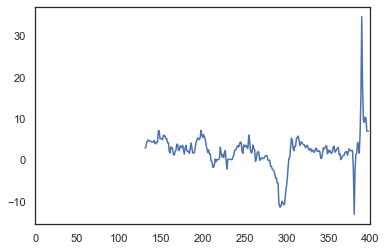

In [67]:
ax = sns.lineplot(data=nontext_train_small['Rsales_diff_year'].values)
ax.set_xlim(0, 400)

(0.0, 400.0)

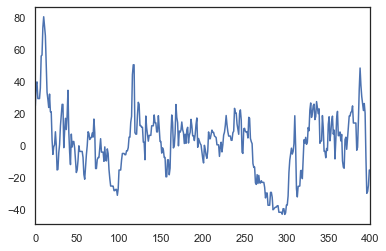

In [68]:
ax = sns.lineplot(data=nontext_ma2['Hsales_diff_year'].values)
ax.set_xlim(0, 400)

In [69]:
# Retail sales growth ratio is difficult to estimate. Though it is not ideal, simply use the average
nontext_train_small['Rsales_diff_year'].fillna(nontext_train_small['Rsales_diff_year'].mean(), inplace=True)
nontext_train_large['Rsales_diff_prev'].fillna(nontext_train_large['Rsales_diff_prev'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year'].fillna(nontext_train_large['Rsales_diff_year'].mean(), inplace=True)

nontext_train_small['Inertia_diff'].fillna(nontext_train_small['Inertia_diff'].mean(), inplace=True)
nontext_train_small['Balanced_diff'].fillna(nontext_train_small['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Inertia_diff'].fillna(nontext_train_large['Inertia_diff'].mean(), inplace=True)
nontext_train_large['Balanced_diff'].fillna(nontext_train_large['Balanced_diff'].mean(), inplace=True)
nontext_train_large['Taylor_diff'].fillna(nontext_train_large['Taylor_diff'].mean(), inplace=True)

nontext_train_large['Rsales_diff_prev_ma3'].fillna(nontext_train_large['Rsales_diff_prev_ma3'].mean(), inplace=True)
nontext_train_large['Rsales_diff_year_ma3'].fillna(nontext_train_large['Rsales_diff_year_ma3'].mean(), inplace=True)

nontext_train_large['Inertia_diff_ma3'].fillna(nontext_train_large['Inertia_diff_ma3'].mean(), inplace=True)
nontext_train_large['Balanced_diff_ma3'].fillna(nontext_train_large['Balanced_diff_ma3'].mean(), inplace=True)
nontext_train_large['Taylor_diff_ma3'].fillna(nontext_train_large['Taylor_diff_ma3'].mean(), inplace=True)
nontext_train_large['Inertia-Rate_ma3'].fillna(nontext_train_large['Inertia-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Balanced-Rate_ma3'].fillna(nontext_train_large['Balanced-Rate_ma3'].mean(), inplace=True)
nontext_train_large['Taylor-Rate_ma3'].fillna(nontext_train_large['Taylor-Rate_ma3'].mean(), inplace=True)


In [70]:
nontext_train_small.isnull().sum()

target              0
prev_decision       0
GDP_diff_prev       0
PMI_value           0
Employ_diff_prev    0
Rsales_diff_year    0
Unemp_diff_prev     0
Inertia_diff        0
Hsales_diff_year    0
Balanced_diff       0
dtype: int64

In [71]:
nontext_train_large.isnull().sum()

target                  0
prev_decision           0
GDP_diff_prev           0
GDP_diff_year           0
GDPPOT_diff_prev        0
GDPPOT_diff_year        0
PCE_diff_prev           0
PCE_diff_year           0
CPI_diff_prev           0
CPI_diff_year           0
Unemp_value             0
Unemp_diff_prev         0
Unemp_diff_year         0
Employ_value            0
Employ_diff_prev        0
Employ_diff_year        0
PMI_value               0
PMI_diff_prev           0
PMI_diff_year           0
Rsales_diff_prev        0
Rsales_diff_year        0
Hsales_diff_prev        0
Hsales_diff_year        0
Taylor-Rate             0
Balanced-Rate           0
Inertia-Rate            0
Taylor_diff             0
Balanced_diff           0
Inertia_diff            0
GDP_diff_prev_ma3       0
GDP_diff_year_ma3       0
GDPPOT_diff_prev_ma3    0
GDPPOT_diff_year_ma3    0
PCE_diff_prev_ma3       0
PCE_diff_year_ma3       0
CPI_diff_prev_ma3       0
CPI_diff_year_ma3       0
Unemp_value_ma3         0
Unemp_diff_p

### One-hot encoding

In [72]:
# nontext_train['Lower'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == -1 else 0)
# nontext_train['Hold'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 0 else 0)
# nontext_train['Raise'] = nontext_train['RateDecision'].apply(lambda x: 1 if x == 1 else 0)
# nontext_train

# Save Data

In [73]:
def save_data(df, file_name, dir_name='../data/train_data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [74]:
# Save non-text data
save_data(nontext_train_small, 'nontext_train_small')
save_data(nontext_train_large, 'nontext_train_large')